# Access Meteolakes Transect Data

This notebook provides an example of how to access the Meteolakes transect data and shows how to process the data.

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from datetime import datetime, timedelta, date
from scipy.interpolate import interp1d

Some processing functions

In [2]:
def tofirstdayinisoweek(year, week):
    ret = datetime.strptime('%04d-%02d-1' % (year, week), '%Y-%W-%w')
    if date(year, 1, 4).isoweekday() > 4:
        ret -= timedelta(days=7)
    return ret

def find_nearest_point(xcoords, ycoords, x, y):
    array = ((xcoords - x)**2 + (ycoords - y)**2)**0.5
    array[np.where(np.isnan(array))] = np.inf
    idx = (np.abs(array)).argmin()
    return xcoords[idx], ycoords[idx], idx

def find_nearest(array, value):
    array[np.where(np.isnan(array))] = np.inf
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

## See available data

This JSON file contains a list of the available lakes, along with the years and weeks that are available

In [3]:
available = requests.get('http://meteolakes.ch/meteolac/available_data.json').json()

## Get transect

http://meteolakes.ch/api/transect/file/:lake/:variable/:location/:year/:week


| Parameter | Description | Acceptable Inputs |
| --- | --- | --- |
| lake | Name of the lake | geneva, zurich, biel, greifensee |
| variable | Variable to return | temperature, velocity |
| location | Location of transect | xz, yz |
| year | Year of data | |
| week | Week of the year | 1 - 52 |

Transect locations:

| Lake | xz | yz |
| --- | --- | --- |
| geneva | Geneva - Villeneuve | Evian - Lausanne |
| zurich | Zurich - Schmerikon | Oberrieden - Herrliberg |
| biel | Saint Johannsen - Biel | Tauffelen - Twann |
| greifensee | South - North | West - East |

The returned csv object has quite a complex structure. It returns a grid of values; x (CH1903), y (CH1903), depth (m), values (xNo timesteps). An example of how to parse the data is provided below.

Define parameters

In [4]:
lake = "geneva"
variable = "temperature"
transect = "xz"
year = 2012
week = 15
interval = 180 # Availble in available_data.json

Call API and transform returned csv into a numpy array

In [5]:
origin_time = tofirstdayinisoweek(year, week)
response = requests.get('https://api.meteolakes.ch/api/transect/file/{}/{}/{}/{}/{}'.format(lake, variable, transect, year, week))
df = pd.DataFrame([x.split(',') for x in response.text.split('\n')])
df.drop(df.tail(1).index,inplace=True)
data = df.to_numpy().astype(np.float)

In [6]:
data

array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [500590., 500590., 500590., ...,     nan,     nan,     nan],
       [500640., 500640., 500640., ...,     nan,     nan,     nan],
       ...,
       [559830., 559830., 559830., ...,     nan,     nan,     nan],
       [560230., 560230., 560230., ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])

## Get transect metadata

http://meteolakes.ch/api/transect/metadata/:lake/:variable/:location/:year/:week

Parameters same as for get transect

In [7]:
transect_metadata = requests.get('https://api.meteolakes.ch/api/transect/metadata/{}/{}/{}/{}/{}'.format(lake, variable, transect, year, week))

In [8]:
tm = transect_metadata.json()

In [9]:
tm

{'Version': 2,
 'GridWidth': 182,
 'GridHeight': 100,
 'Timesteps': 49,
 'NumberOfValues': 1,
 'NumberOfCoordinates': 3}

## Parse the transect data

In [10]:
xcoords = data[0:tm["GridWidth"],0:tm["GridHeight"]][:,0]
ycoords = data[0:tm["GridWidth"],tm["GridHeight"]:tm["GridHeight"]*2][:,0]
depths = data[0:tm["GridWidth"],tm["GridHeight"]*2:tm["GridHeight"]*3]
timesteps = []
for i in range(tm["Timesteps"]):
    timesteps.append({"datetime": origin_time + timedelta(minutes=interval*i), 
                      "data": data[0:tm["GridWidth"],tm["GridHeight"]*(i+3):tm["GridHeight"]*(i+4)]})

### Plot temperature

This is a simple temperature plot not corrected for depth or location.

In [11]:
timestep = 0

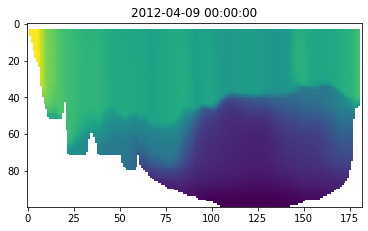

In [12]:
plt.imshow(np.rot90(timesteps[timestep]["data"]))
plt.title(timesteps[timestep]["datetime"])
plt.show()

### Plot Temperature Advanced

This is a temperature plot adjusted for distance along the transect and depth resampled to a fixed grid.

Get distance along transect

In [13]:
distance = [0]
for i in range(1, tm["GridWidth"]):
    if (np.isnan(xcoords[i]) or 
        np.isnan(xcoords[i-1]) or 
        np.isnan(ycoords[i]) or 
        np.isnan(ycoords[i-1]) ):
        distance.append(distance[i-1])
    else:
        distance.append(distance[i-1] + ((xcoords[i]-xcoords[i-1])**2 + (ycoords[i]-ycoords[i-1])**2) ** 0.5)

Resample to fixed depth grid

In [14]:
no_depths = 200
depths[np.isnan(timesteps[timestep]["data"])] = np.nan # Remove not applied values
min_depth = np.nanmax(depths)
max_depth = np.nanmin(depths)
depth_grid = np.linspace(min_depth,max_depth, no_depths)
values = np.empty((tm["GridWidth"], no_depths))
values[:] = np.nan

for i in range(tm["GridWidth"]):
    interpolate = interp1d(depths[i,:], timesteps[timestep]["data"][i,:], fill_value=np.nan)
    d_max = np.nanmin(depths[i,:])
    d_min = np.nanmax(depths[i,:])
    for j in range(no_depths):
        if (d_min >= depth_grid[j] >= d_max):
            values[i,no_depths - j - 1] = interpolate(depth_grid[j])
        else:
            values[i, no_depths - j - 1] = np.nan

C:\Users\runnalja\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()
C:\Users\runnalja\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
C:\Users\runnalja\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Plot the result

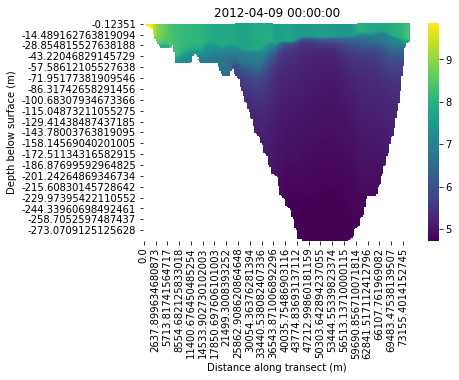

In [15]:
df = pd.DataFrame(data=np.rot90(values), columns=distance, index=depth_grid)
sns.heatmap(df, square=False, cmap="viridis")
plt.title(timesteps[timestep]["datetime"])
plt.xlabel("Distance along transect (m)")
plt.ylabel("Depth below surface (m)")
plt.show()

## Access Timeseries Data

Define Parameters

In [16]:
lake = "geneva"
variable = "temperature"
transect = "xz"
x = 501740
y = 123070
z = -30
start = datetime(2010,1,1)
end = datetime(2011,12,31)
interval = 180 # Availble in available_data.json

Use the first timestep to get the index of the closest point to desired location

In [17]:
start_year = start.isocalendar()[0]
start_week = start.isocalendar()[1]
end_year = end.isocalendar()[0]
end_week = end.isocalendar()[1]

transect_metadata = requests.get('https://api.meteolakes.ch/api/transect/metadata/{}/{}/{}/{}/{}'.format(lake, variable, transect, start_year, start_week))
tm = transect_metadata.json()

response = requests.get('https://api.meteolakes.ch/api/transect/file/{}/{}/{}/{}/{}'.format(lake, variable, transect, start_year, start_week))
df = pd.DataFrame([x.split(',') for x in response.text.split('\n')])
df.drop(df.tail(1).index,inplace=True)
data = df.to_numpy().astype(np.float)
xcoords = data[0:tm["GridWidth"],0:tm["GridHeight"]][:,0]
ycoords = data[0:tm["GridWidth"],tm["GridHeight"]:tm["GridHeight"]*2][:,0]
depths = data[0:tm["GridWidth"],tm["GridHeight"]*2:tm["GridHeight"]*3]

x_a, y_a, idx = find_nearest_point(xcoords, ycoords, x, y)
print("Closest point to ["+str(x)+","+str(y)+"] is ["+str(x_a)+","+str(y_a)+"] at index "+str(idx))
z_a, idz = find_nearest(depths[idx, :], z)
print("Closest depth to "+str(z)+"m is "+str(z_a)+"m at index "+str(idz))

Closest point to [501740,123070] is [501740.0,123070.0] at index 15
Closest depth to -30m is -30.498m at index 49


Iterate over weeks to get values for time series

In [18]:
time_arr = []
var_arr = []
for yr in range(start_year, end_year+1):
    s, e = 1, 52
    if yr == start_year:
        s = start_week
    if yr == end_year:
        e = end_week
    for wk in range(s, e+1):
        response = requests.get('https://api.meteolakes.ch/api/transect/file/{}/{}/{}/{}/{}'.format(lake, variable, transect, yr, wk))
        if response.status_code == 200:
            df = pd.DataFrame([x.split(',') for x in response.text.split('\n')])
            df.drop(df.tail(1).index,inplace=True)
            data = df.to_numpy().astype(np.float)
            origin_time = tofirstdayinisoweek(yr, wk)
            for i in range(tm["Timesteps"]):
                time_arr.append(origin_time + timedelta(minutes=interval*i))
                var_arr.append(data[0:tm["GridWidth"],tm["GridHeight"]*(i+3):tm["GridHeight"]*(i+4)][idx, idz])

Plot the temperature time series data

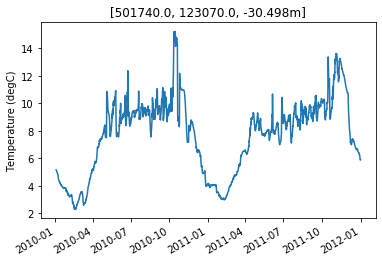

In [19]:
fig, ax = plt.subplots()
ax.plot(time_arr,var_arr)
fig.autofmt_xdate()
plt.title("["+str(x_a)+", "+str(y_a)+", "+str(z_a)+"m]")
plt.ylabel("Temperature (degC)")
plt.show()